<a href="https://colab.research.google.com/github/GarettGazay/ai_projects/blob/master/otp_minutes_LSTM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [402]:
# Import required libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [403]:
df = pd.read_csv('/content/2022_otp_runs.csv')

In [404]:
# df = df.drop(['pickup_month', 'pickup_day', 'median_pickup_time_hour'],axis=1)

In [405]:
df.head()

,pickup_day,pickup_lng,pickup_lat,median_pickup_time_hour,median_pickup_time_minute,median_dropoff_time_hour,median_dropoff_time_minute,dropoff_lng,dropoff_lat,start_dropoff_lng,start_dropoff_lat,start_median_dropoff_time_hour,start_median_dropoff_time_minute,billable_distance
0,0.008125,-0.989852,0.847646,0.333333,0.366667,0.333333,0.733333,-0.989807,0.302661,-0.989852,0.303341,0.333333,0.366667,0.088237
1,0.008125,-0.990825,0.848788,0.166667,0.383333,0.166667,0.800000,-0.990424,0.303688,-0.990825,0.303750,0.166667,0.383333,0.057734
2,0.008125,-0.990922,0.846670,0.208333,0.050000,0.208333,0.516667,-0.990674,0.303178,-0.990424,0.303688,0.166667,0.800000,0.029978
3,0.008125,-0.990800,0.846893,0.208333,0.216667,0.208333,0.483333,-0.990674,0.303178,-0.990674,0.303178,0.208333,0.516667,0.017937
4,0.008125,-0.989395,0.845235,0.458333,0.133333,0.458333,0.766667,-0.990521,0.303068,-0.989395,0.302478,0.458333,0.133333,0.109662


In [406]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(df)) # 80% train, 20% test
split_size

21879

In [407]:
X_minute = df

In [408]:
y_minute = X_minute["median_pickup_time_minute"]
X_minute = X_minute.drop(['median_pickup_time_minute'], axis=1)

In [409]:
# Create train data splits (everything before the split)
X_train, y_train = X_minute[:split_size], y_minute[:split_size]

In [410]:
y_train.head(25)

0     0.366667
1     0.383333
2     0.050000
3     0.216667
4     0.133333
5     0.716667
6     0.983333
7     0.850000
8     0.966667
9     0.333333
10    0.033333
11    0.050000
12    0.933333
13    0.366667
14    0.016667
15    0.950000
16    0.933333
17    0.566667
18    0.966667
19    0.783333
20    0.616667
21    0.716667
22    0.033333
23    0.866667
24    0.316667
Name: median_pickup_time_minute, dtype: float64

In [411]:
# Create test data splits (everything after the split)
X_test, y_test = X_minute[split_size:], y_minute[split_size:]

In [412]:
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

# X_train.dtypes, y_train.dtypes, X_test.dtypes, y_test.dtypes

In [413]:
X_train.head()

,pickup_day,pickup_lng,pickup_lat,median_pickup_time_hour,median_dropoff_time_hour,median_dropoff_time_minute,dropoff_lng,dropoff_lat,start_dropoff_lng,start_dropoff_lat,start_median_dropoff_time_hour,start_median_dropoff_time_minute,billable_distance
0,0.008125,-0.989852,0.847646,0.333333,0.333333,0.733333,-0.989807,0.302661,-0.989852,0.303341,0.333333,0.366667,0.088237
1,0.008125,-0.990825,0.848788,0.166667,0.166667,0.800000,-0.990424,0.303688,-0.990825,0.303750,0.166667,0.383333,0.057734
2,0.008125,-0.990922,0.846670,0.208333,0.208333,0.516667,-0.990674,0.303178,-0.990424,0.303688,0.166667,0.800000,0.029978
3,0.008125,-0.990800,0.846893,0.208333,0.208333,0.483333,-0.990674,0.303178,-0.990674,0.303178,0.208333,0.516667,0.017937
4,0.008125,-0.989395,0.845235,0.458333,0.458333,0.766667,-0.990521,0.303068,-0.989395,0.302478,0.458333,0.133333,0.109662


In [414]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='mae', patience=5)

In [415]:
X_train.shape

(21879, 13)

In [416]:
X_train = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
# Create a new model
minute_model = tf.keras.Sequential([
  tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dense(1)
])

# Compile the model
minute_model.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['mae'],
                )

history = minute_model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=32,
    validation_split=0.1,
    verbose=2,
    callbacks=[early_stopping]
    )

# X_train = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])

# minute_model = tf.keras.Sequential()

# # Add a GRU layer with 128 units and return the full sequence of outputs
# minute_model.add(tf.keras.layers.GRU(128, return_sequences=True, input_shape=(None, 13) ))
# # Add another GRU layer with 64 units
# minute_model.add(tf.keras.layers.GRU(64))
# # Add a dense layer with 10 units and a softmax activation function
# minute_model.add(tf.keras.layers.Dense(1, activation='linear'))

# # Compile the model with a categorical crossentropy loss function and an Adam optimizer
# minute_model.compile(loss='mae', optimizer='adam')

# history = minute_model.fit(
#     X_train,
#     y_train,
#     epochs=500,
#     batch_size=32,
#     validation_split=0.1,
#     verbose=2,
#     callbacks=[early_stopping]
#     )




# Create a new model (same as model_2)
# minute_model = tf.keras.Sequential([
#   tf.keras.layers.Dense(34, activation='relu'),
#   tf.keras.layers.Dense(34, activation='relu'),
#   tf.keras.layers.Dense(16, activation='relu'),
#   tf.keras.layers.Dense(1)
# ])

# # Compile the model
# minute_model.compile(loss=tf.keras.losses.mae,
#                 optimizer=tf.keras.optimizers.Adam(),
#                 metrics=['mae'],
#                 )

# history = minute_model.fit(
#     X_train,
#     y_train,
#     epochs=500,
#     batch_size=32,
#     validation_split=0.1,
#     verbose=2,
#     callbacks=[early_stopping]
#     )


# # Create a new model
# minute_model = tf.keras.Sequential([
#   tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
#   tf.keras.layers.LSTM(25),
#   tf.keras.layers.Dense(1)
# ])

# # Compile the model
# minute_model.compile(loss=tf.keras.losses.mae,
#                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#                 metrics=['mae'],
#                 )

# history = minute_model.fit(
#     X_train,
#     y_train,
#     epochs=500,
#     batch_size=32,
#     validation_split=0.1,
#     verbose=2,
#     callbacks=[early_stopping]
#     )



Epoch 1/500
616/616 - 8s - loss: 0.3076 - mae: 0.3076 - val_loss: 0.2494 - val_mae: 0.2494 - 8s/epoch - 13ms/step
Epoch 2/500
616/616 - 3s - loss: 0.2537 - mae: 0.2537 - val_loss: 0.2460 - val_mae: 0.2460 - 3s/epoch - 5ms/step
Epoch 3/500
616/616 - 3s - loss: 0.2504 - mae: 0.2504 - val_loss: 0.2423 - val_mae: 0.2423 - 3s/epoch - 5ms/step
Epoch 4/500
616/616 - 3s - loss: 0.2477 - mae: 0.2477 - val_loss: 0.2397 - val_mae: 0.2397 - 3s/epoch - 5ms/step
Epoch 5/500
616/616 - 3s - loss: 0.2455 - mae: 0.2455 - val_loss: 0.2389 - val_mae: 0.2389 - 3s/epoch - 5ms/step
Epoch 6/500
616/616 - 3s - loss: 0.2436 - mae: 0.2436 - val_loss: 0.2373 - val_mae: 0.2373 - 3s/epoch - 5ms/step
Epoch 7/500
616/616 - 3s - loss: 0.2422 - mae: 0.2422 - val_loss: 0.2354 - val_mae: 0.2354 - 3s/epoch - 5ms/step
Epoch 8/500
616/616 - 3s - loss: 0.2406 - mae: 0.2406 - val_loss: 0.2333 - val_mae: 0.2333 - 3s/epoch - 5ms/step
Epoch 9/500
616/616 - 3s - loss: 0.2389 - mae: 0.2389 - val_loss: 0.2315 - val_mae: 0.2315 - 3s

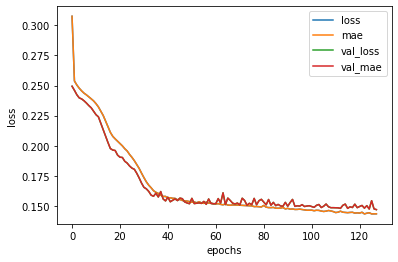

In [417]:
# Plot history (also known as a loss curve)
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs");

In [418]:
y_pred = minute_model.predict(X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1]))

171/171 [==============================] - 1s 3ms/step


In [419]:
result = pd.DataFrame(X_test)

In [420]:
y_pred = tf.squeeze(y_pred)

In [421]:
y_pred = np.array(y_pred)

In [422]:
result['y_pred(minute)'] = np.array(y_pred)

In [423]:
result.head()

,pickup_day,pickup_lng,pickup_lat,median_pickup_time_hour,median_dropoff_time_hour,median_dropoff_time_minute,dropoff_lng,dropoff_lat,start_dropoff_lng,start_dropoff_lat,start_median_dropoff_time_hour,start_median_dropoff_time_minute,billable_distance,y_pred(minute)
21879,0.024374,-0.987700,0.841094,0.333333,0.333333,0.700000,0.302478,-0.989395,-0.987700,0.300996,0.333333,0.300000,0.167669,0.246446
21880,0.024374,-0.990655,0.847091,0.375000,0.416667,0.166667,0.303044,-0.990834,0.302478,-0.989395,0.333333,0.700000,0.022274,0.634976
21881,0.024374,-0.990703,0.847379,0.416667,0.416667,0.900000,0.302669,-0.990499,0.303044,-0.990834,0.416667,0.166667,0.069765,0.494666
21882,0.024374,-0.990704,0.847378,0.416667,0.458333,0.350000,0.303230,-0.990954,0.302669,-0.990499,0.416667,0.900000,0.015135,0.709017
21883,0.024374,-0.990910,0.845958,0.500000,0.541667,0.233333,0.303052,-0.990221,0.303230,-0.990954,0.458333,0.350000,0.091094,0.487949


In [424]:
result = pd.DataFrame([result['start_median_dropoff_time_minute'], result['y_pred(minute)']])

In [425]:
y_pred[:10]

array([0.25, 0.63, 0.49, 0.71, 0.49, 0.62, 0.55, 0.76, 0.33, 0.68],
      dtype=float32)

In [426]:
np.set_printoptions(precision=2)
compare = np.concatenate((y_pred.reshape(len(y_pred),1), y_test.values.reshape(len(y_test),1)),1)

for i in compare[5000:5050]:
  print(i)

[0.84 0.82]
[0.44 0.15]
[0.68 0.82]
[0.59 0.58]
[0.94 0.95]
[0.77 0.78]
[0.39 0.43]
[0.49 0.75]
[1.03 0.47]
[0.8  0.13]
[0.48 0.58]
[0.52 0.83]
[0.59 0.77]
[0.13 0.08]
[0.88 0.77]
[0.51 0.58]
[0.46 0.  ]
[0.95 0.95]
[0.48 0.67]
[0.45 0.4 ]
[0.44 0.3 ]
[0.49 0.25]
[0.71 0.77]
[0.68 0.6 ]
[0.25 0.22]
[0.79 0.75]
[0.46 0.5 ]
[0.57 0.65]
[0.63 0.82]
[0.59 0.88]
[0.4  0.13]
[0.09 0.05]
[0.77 0.87]
[0.58 0.55]
[0.11 0.1 ]
[0.59 0.18]
[0.57 0.62]
[0.22 0.23]
[0.74 0.98]
[0.18 0.12]
[0.8  0.85]
[1.45 0.15]
[0.45 0.63]
[0.12 0.42]
[0.58 0.92]
[0.32 0.12]
[0.55 0.57]
[0.16 0.25]
[0.77 0.78]
[0.5  0.52]


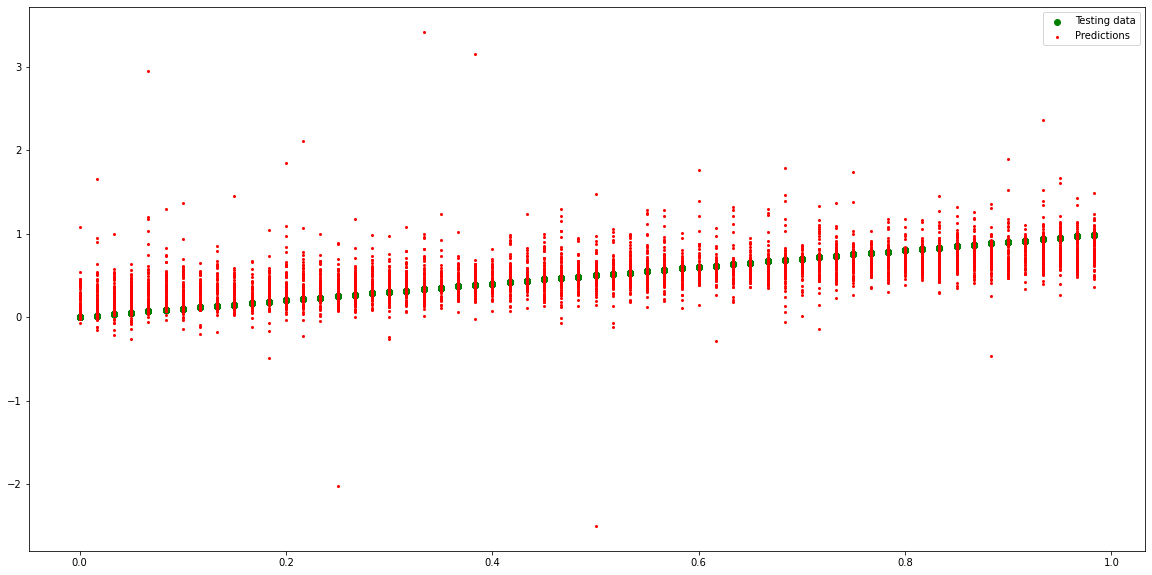

In [427]:
  plt.figure(figsize=(20, 10))

  # Plot test data in green
  plt.scatter(y_test[:5470], y_test[:5470], c="g", label="Testing data")

  # Plot the predictions in red (predictions were made on the test data)
  plt.scatter(y_test[:5470], y_pred[:5470], c="r", s=4, label="Predictions")
  # Show the legend
  plt.legend();

In [428]:
y_test.shape

(5470,)

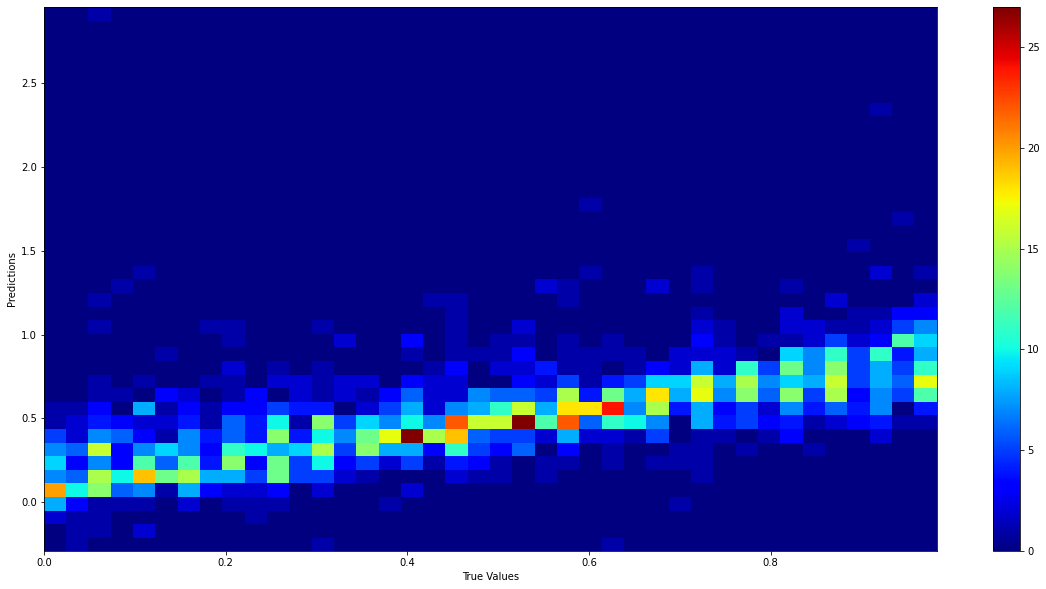

In [429]:


y_pred_heat = np.array(tf.squeeze(y_pred))
y_pred_heat.shape, y_test.shape

y_pred_heat[:10]
y_test[:10]

plt.figure(figsize=(20, 10))
plt.hist2d(y_test[:2000], np.array(tf.squeeze(y_pred))[:2000], bins=40, cmap='jet')
plt.colorbar()
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

